# Assignment 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load data:
data = pd.read_csv("A3_BitcoinTransactions.csv")

firstDate = data["Date"].iloc[0]
lastDate = data["Date"].iloc[-1]

# Split data into training and testing:
trainSize = 3146
trainData, testData = train_test_split(data, train_size= trainSize, shuffle= False)

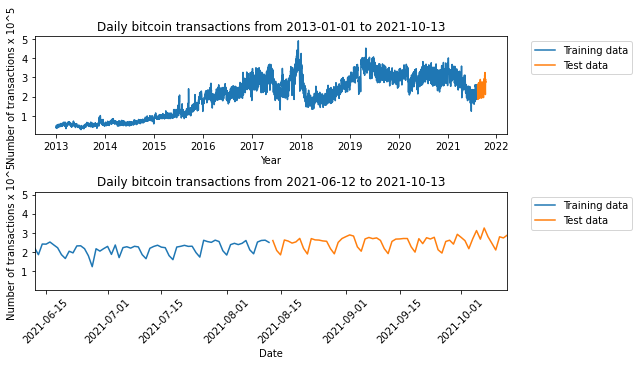

In [3]:
# Plot data:
plt.figure("BitcoinTransactions", figsize=(9,5))
plt.subplot(211)
plt.plot(pd.to_datetime(trainData["Date"]) ,trainData["BitcoinTransactions"])
plt.plot(pd.to_datetime(testData["Date"]), testData["BitcoinTransactions"])
plt.title(f"Daily bitcoin transactions from {firstDate} to {lastDate}")
plt.xlabel("Year")
plt.ylabel("Number of transactions x 10^5")
plt.legend(["Training data", "Test data"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(ticks= [100000, 200000, 300000, 400000, 500000], labels= [1, 2, 3, 4, 5])

firstDateZoomed = trainData["Date"].iloc[-len(testData)]
lastDateZoomed = lastDate

plt.subplot(212)
plt.plot(pd.to_datetime(trainData["Date"]),trainData["BitcoinTransactions"])
plt.plot(pd.to_datetime(testData["Date"]), testData["BitcoinTransactions"])
plt.title(f"Daily bitcoin transactions from {firstDateZoomed} to {lastDateZoomed}")
plt.xlabel("Date")
plt.ylabel("Number of transactions x 10^5")
plt.legend(["Training data", "Test data"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim(pd.Timestamp(firstDateZoomed), pd.Timestamp(lastDateZoomed))
plt.yticks(ticks= [100000, 200000, 300000, 400000, 500000], labels= [1, 2, 3, 4, 5])
plt.xticks(rotation= 45)

plt.tight_layout()

# Save plot:
plt.savefig("figures/BitcoinTransactions.png", dpi= 300)

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


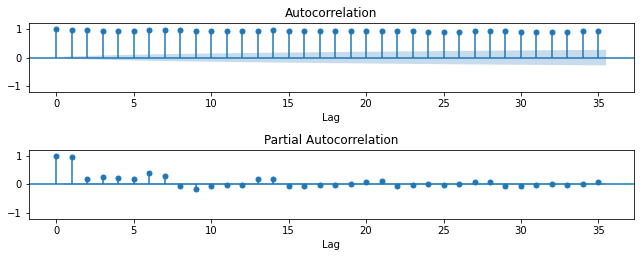

In [4]:
# Plot acf and pacf:
fig = plt.figure(figsize= (9,5))
ax1 = plt.subplot(311)
acfPlot = plot_acf(trainData["BitcoinTransactions"], ax1)
plt.ylim((-1.2, 1.2))
ax1.set_xlabel("Lag")

ax2 = plt.subplot(312)
pacfPlot = plot_pacf(trainData["BitcoinTransactions"], ax2)
plt.ylim((-1.2, 1.2))
ax2.set_xlabel("Lag")

plt.tight_layout()

fig.savefig("figures/acfpacfPlot.png", dpi= 300)

### Model plot
The above time series are non-stationary with both the mean and variance changing over time. This implies ARIMA model with the "I" term to compansate for the non-stationarity. Also from the lower plot is is clear that there are som daily patterns in the data. These patterns is an indicator that some kind of seasonality can be included in the model.

In order to find the order of the "d" part of the ARIMA model, differentiation is used. The order of the "d" is the number of differentiations that need to be used in order to get a sufficiently fast decrease in the autocorrelation function.

### Autocorrelation plot:
The autocorrelation plot are very slowly decaying. This is a clear sign of non-stationarity.

### Partial autocorrelation plot:
From this plot there looks to be seasonality in the MA part of the model. This can be seen as the significant spikes in the data with a periodicity of approximatley 12.

### Transformations:
To "make" this process stationary transformation and differencing are used. 

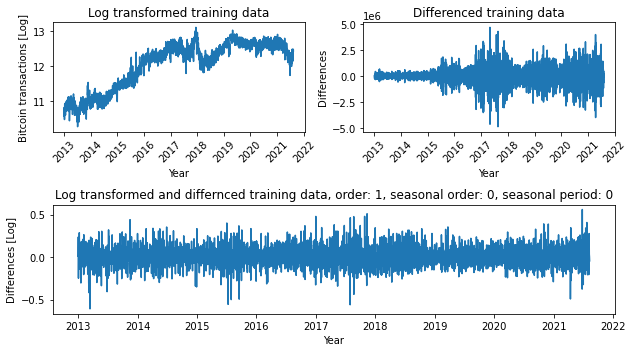

In [239]:
# Order of differencing:
diffOrder = 1
seasonalDiffOrder = 0
seasonal_periods = 0

# Do the log transformation and differencing:
logTrainData = np.log(np.array(trainData["BitcoinTransactions"]))
diffTrainData = diff(np.array(trainData["BitcoinTransactions"]), 7)

diffLogTrainData = diff(logTrainData, k_diff= diffOrder , k_seasonal_diff= seasonalDiffOrder, seasonal_periods= seasonal_periods)

# Plotting:
plt.figure(figsize= (9, 5))
plt.subplot(221)
plt.plot(pd.to_datetime(trainData["Date"]), logTrainData)
plt.title("Log transformed training data")
plt.ylabel("Bitcoin transactions [Log]")
plt.xlabel("Year")
plt.xticks(rotation= 45)

plt.subplot(222)
plt.plot(pd.to_datetime(trainData["Date"]).iloc[:len(diffTrainData)], diffTrainData)
plt.title(f"Differenced training data")
plt.xlabel("Year")
plt.ylabel("Differences")
#plt.yticks(ticks= [-150000, -100000, -50000, 0, 50000, 100000], labels= [-15, -10, -5, 0, 5, 10])
plt.xticks(rotation= 45)

plt.subplot(212)
plt.plot(pd.to_datetime(trainData["Date"]).iloc[:len(diffLogTrainData)], diffLogTrainData)
plt.title(f"Log transformed and differnced training data, order: {diffOrder}, seasonal order: {seasonalDiffOrder}, seasonal period: {seasonal_periods}")
plt.ylabel("Differences [Log]")
plt.xlabel("Year")

plt.tight_layout()

# Save plot:
#plt.savefig("figures/transformedDifferenced.png", dpi= 300)

### Differentiation:
The above plots are used to find the "d" term in the ARIMA model. We are supposed to find the order of the differentiation that results in a fast enough decrease in the autocorrelation function. By trying different orders, the correct "d" looks to be either 1 or 2.

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


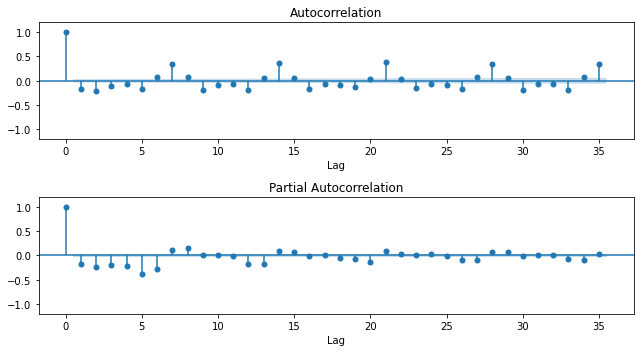

In [240]:
# Plot acf and pacf:
fig = plt.figure(figsize= (9,5))
ax1 = plt.subplot(211)
acfPlot = plot_acf(diffLogTrainData, ax1)
plt.ylim((-1.2, 1.2))
ax1.set_xlabel("Lag")

ax2 = plt.subplot(212)
pacfPlot = plot_pacf(diffLogTrainData, ax2)
plt.ylim((-1.2, 1.2))
ax2.set_xlabel("Lag")

plt.tight_layout()

#fig.savefig("figures/TransformedAcfpacfPlot1.png", dpi= 300)

In [74]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

from check_model import check_model

def grid_search(data, orders):
	scores = None
	# execute configs in parallel
	executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
	tasks = (delayed(check_model)(data, order) for order in orders)
	scores = executor(tasks)
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	return scores

In [191]:
possible_q = [1, 2, 3, 4]
possible_Q = [1, 2, 3, 4]

orders = []

for q in possible_q:
    for Q in possible_Q:
                    order = (0, 1, q)
                    seasonal_order = (0, 1, Q, 7)
                    orders.append([order, seasonal_order])

if __name__ == '__main__': 
    scores = grid_search(logTrainData, orders)


[(0, 1, 1), (0, 1, 1, 7)]
[(0, 1, 1), (0, 1, 2, 7)]
[(0, 1, 1), (0, 1, 3, 7)]
[(0, 1, 1), (0, 1, 4, 7)]
[(0, 1, 2), (0, 1, 1, 7)]
[(0, 1, 2), (0, 1, 2, 7)]
[(0, 1, 2), (0, 1, 3, 7)]
[(0, 1, 2), (0, 1, 4, 7)]
[(0, 1, 3), (0, 1, 1, 7)]
[(0, 1, 3), (0, 1, 2, 7)]
[(0, 1, 3), (0, 1, 3, 7)]
[(0, 1, 3), (0, 1, 4, 7)]
[(0, 1, 4), (0, 1, 1, 7)]
[(0, 1, 4), (0, 1, 2, 7)]
[(0, 1, 4), (0, 1, 3, 7)]
[(0, 1, 4), (0, 1, 4, 7)]


In [244]:
AIC = []

[AIC.append(order[1]) for order in scores]

print(scores[AIC.index(min(AIC))])

[[(0, 1, 3), (0, 1, 1, 7)], -6285.043795846583, -6254.804649059293, -6274.189771746249, 0.6682761841884854]


In [236]:
# Order of the model:
order = (6, 1, 1)
seasonal_order = (0, 1, 1, 7)

model = SARIMAX(logTrainData,
                order= order, 
                seasonal_order= seasonal_order,
                enforce_stationarity= False,
                enforce_invertibility= False)

res = model.fit(disp= False)

In [237]:
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3146
Model:             SARIMAX(6, 1, 1)x(0, 1, 1, 7)   Log Likelihood                3161.490
Date:                           Tue, 23 Nov 2021   AIC                          -6304.980
Time:                                   12:04:23   BIC                          -6250.543
Sample:                                        0   HQIC                         -6285.441
                                          - 3146                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4622      0.015     31.838      0.000       0.434       0.491
ar.L2          0.1131      0.015      7.403

### Residual analysis:

       lb_stat      lb_pvalue
1    64.624829   9.060639e-16
2    65.719963   5.359093e-15
3    71.799908   1.757022e-15
4    71.962250   8.741299e-15
5    72.039894   3.853640e-14
6    72.043096   1.556813e-13
7   587.426854  1.241116e-122
8   655.606730  2.567302e-136
9   656.160313  1.826114e-135
10  657.124396  9.972704e-135


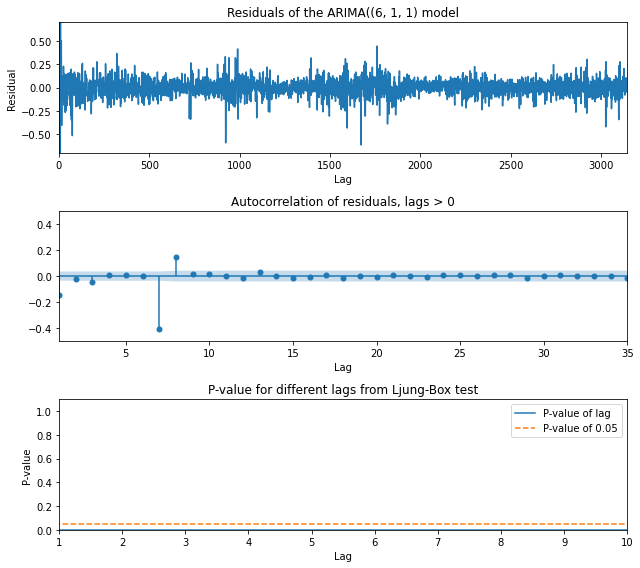

In [238]:
# Extracting the residuals
residuals = res.resid

# Ljung-box test:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungBox = acorr_ljungbox(residuals, lags= 10)
print(ljungBox)

# Plot the residuals:
fig = plt.figure(figsize= (9, 8))

plt.subplot(311)
plt.plot(residuals)
plt.title(f"Residuals of the ARIMA({order} model")
plt.xlabel("Lag")
plt.ylabel("Residual")
plt.ylim(-0.7, 0.7)
plt.xlim(0, trainSize)

ax2 = plt.subplot(312)
fig = plot_acf(residuals, ax2)
ax2.set_title("Autocorrelation of residuals, lags > 0")
ax2.set_xlabel("Lag")
ax2.set_xlim(1, 35)
ax2.set_ylim(-0.5, 0.5)

plt.subplot(313)
ljungBox.lb_pvalue.plot()
plt.ylim(0, 1.1)
plt.xlim(1, len(ljungBox))
plt.plot(np.ones(21) * 0.05, "--")
plt.title("P-value for different lags from Ljung-Box test")
plt.xlabel("Lag")
plt.ylabel("P-value")
plt.legend(["P-value of lag", "P-value of 0.05"])

plt.tight_layout()

#fig.savefig("figures/ResidualsAR.png", dpi= 300)

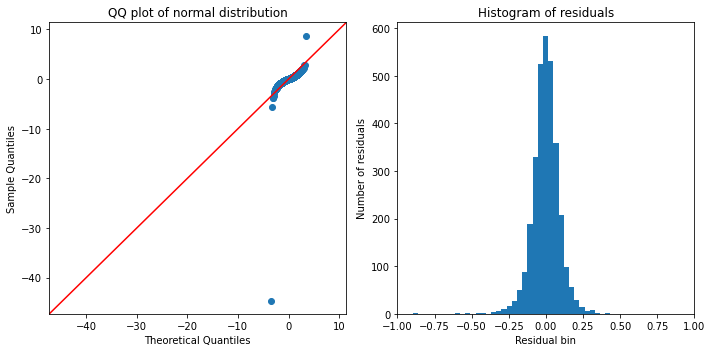

In [233]:
from statsmodels.graphics.gofplots import qqplot

fig = plt.figure(figsize= (10, 5))
ax = plt.subplot(121)
qqplot(residuals[1:len(residuals) - 1], line= "45", fit= True, ax= ax)
ax.set_title("QQ plot of normal distribution")

plt.subplot(122)
plt.hist(residuals, bins= 500)
plt.xlim(-1, 1)
plt.title("Histogram of residuals")
plt.xlabel("Residual bin")
plt.ylabel("Number of residuals")

plt.tight_layout()

#fig.savefig("figures/QQplotHistogram.png", dpi= 300)

## Pediction:

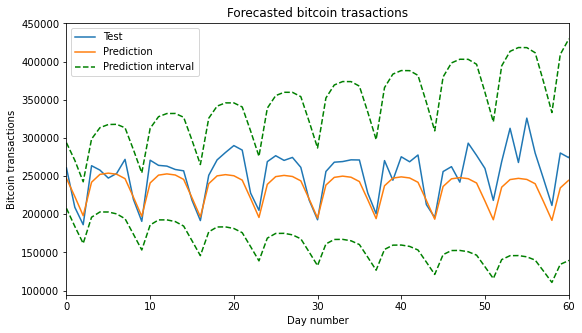

In [234]:
forecast = res.get_forecast(len(testData))

# Do the log transformation and differencing:
logTestData = np.log(np.array(testData["BitcoinTransactions"]))
diffTestData = diff(np.array(testData["BitcoinTransactions"]))

diffLogTestData = diff(logTestData, diffOrder)

# Extract the prediction interval:
predictionInterval = forecast.conf_int()

# Transform the log transfomred data back:
#prediction = np.exp(forecast.predicted_mean + forecast.var_pred_mean/2)

fig = plt.figure(figsize= (9, 5))
plt.plot(np.array(testData["BitcoinTransactions"]))
plt.plot(np.exp(forecast.predicted_mean))
plt.plot(np.exp(predictionInterval), "--", color= "green")
plt.legend(["Test", "Prediction", "Prediction interval"])
plt.title("Forecasted bitcoin trasactions")
plt.xlabel("Day number")
plt.ylabel("Bitcoin transactions")
plt.xlim(0, 60)

fig.savefig("figures/forecast.png", dpi= 300)

In [235]:
days = [1, 2, 14, 31, 61]

print(f"True values: ")
for day in days:
    true = testData["BitcoinTransactions"].iloc[day - 1]
    print(f"Day {day}: {true}")
print("\n")

print(f"Predicted values: ")
for day in days:
    predicted = np.exp(forecast.predicted_mean[day - 1])
    print(f"Day {day}: {round(predicted, 2)}")
print("\n")

print(f"Prediction interval: ")
for day in days:
    interval = np.exp(predictionInterval[day - 1])
    print(f"Day {day}: lower: {round(interval[0], 2)}, upper: {round(interval[1], 2)}")

True values: 
Day 1: 260624
Day 2: 209074
Day 14: 258590
Day 31: 192691
Day 61: 274155


Predicted values: 
Day 1: 246936.06
Day 2: 223117.34
Day 14: 251360.87
Day 31: 194973.87
Day 61: 244418.79


Prediction interval: 
Day 1: lower: 207675.29, upper: 293619.02
Day 2: lower: 184003.6, upper: 270545.51
Day 14: lower: 190319.82, upper: 331979.55
Day 31: lower: 132580.29, upper: 286730.47
Day 61: lower: 139214.07, upper: 429127.22
